<a href="https://colab.research.google.com/github/gretaangolani/Text-Mining-and-Sentiment-Analysis/blob/main/ABSAFINALPJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STEP 0: Importing Libriries and Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive') #connect to drive

Mounted at /content/drive


In [2]:
!pip install bornrule
!pip install wordcloud matplotlib

In [3]:
import re
import spacy
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from bornrule import BornClassifier
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
file_path= '/content/drive/MyDrive/sentiment/AWARE_Social_Networking.csv'
df=pd.read_csv(file_path)

In [5]:
df1 = df.filter(items=['review', 'sentiment', 'term'])  #columns to keep
df1['doc_id'] = df1.index #add document_id
df1

,review,sentiment,term,doc_id
0,I like WhatsApp to talk to friends that aren’t...,negative,video call,0
1,"As a mobile user, it is unfortunate that we ca...",negative,share,1
2,Does everything the desktop app does! Slight b...,negative,volume,2
3,I logged in today and my credits and history w...,negative,phone call,3
4,"I’ve been using Skype for years as a gamer, an...",negative,recent update,4
...,...,...,...,...
3113,Man DON’T update to latest version. My phone d...,negative,version,3113
3114,"Save your money, cuz it's buggy af! It keeps ...",negative,NaN,3114
3115,The Facebook app shows that it was updated tod...,negative,data,3115
3116,I have been on Facebook for a very long time. ...,negative,account,3116


In [6]:
df1[['review', 'sentiment']].isnull().any()

,0
review,False
sentiment,False


In [7]:
df1.drop_duplicates(subset=['review', 'sentiment'], inplace=True)

In [8]:
negative = df1[df1['sentiment'] == 'negative']
positive = df1[df1['sentiment'] == 'positive']

# Undersampling of the majority class (negative)
negative_downsampled = resample(negative,
                                replace=False,    #resampling without substitution
                                n_samples=len(positive),
                                random_state=42)

df_balanced = pd.concat([negative_downsampled, positive])

In [9]:
# Calculate sentiment counts
cat_counts_df = df1['sentiment'].value_counts()
cat_counts_df


,count
sentiment,
negative,1066
positive,908


#STEP 1: Pre processing

In [10]:
nlp = spacy.load("en_core_web_sm") #load spacy

def clean_word(word):
    if re.search(r'(.)\1{2,}', word): #remove words with more than 3 characters repeated consecutively
        return False
    if len(word) < 4:
        return False
    return True

def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = []
    tagged_tokens = []
    negation_flag = False

    for token in doc:
        if token.dep_ == "neg":
            negation_flag = True

        if token.is_alpha and not token.is_stop and clean_word(token.text):
            lemma = token.lemma_.lower()

            if negation_flag:
                lemmatized_tokens.append("not")  #add "not" for negation
                negation_flag = False

            lemmatized_tokens.append(lemma)
            tagged_tokens.append((token.text, token.pos_, token.dep_))  #add POS and dependencies

    return lemmatized_tokens, tagged_tokens

def extract_subject_object_nouns(pos_tagged_tokens):
    nouns_aspects = []
    for token, pos, dep in pos_tagged_tokens:
        if pos == "NOUN" and dep in ("nsubj", "dobj", "compound"):
            nouns_aspects.append(token)
    return nouns_aspects

# Funzione per dividere il testo in frasi usando spaCy
def split_into_sentences(text, delimiter=" | "): #split text into sentences
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return delimiter.join(sentences)

In [11]:
df_balanced['lemmatized_text'] = df_balanced['review'].apply(lambda x: " ".join(preprocess_text(x)[0]))  # tokens lemmatized and filtered
df_balanced['pos_tagged'] = df_balanced['review'].apply(lambda x: preprocess_text(x)[1])  # tokens with POS tagging and dependencies
df_balanced['sentences'] = df_balanced['review'].apply(lambda x: split_into_sentences(x, delimiter=" | ")) #get sentences
df_balanced['subject_object_nouns'] = df_balanced['pos_tagged'].apply(lambda x: [word.lower() for word in extract_subject_object_nouns(x)]) #get subject/object/compound nouns

df_balanced.head()

,review,sentiment,term,doc_id,lemmatized_text,pos_tagged,sentences,subject_object_nouns
41,This update did nothing to fix my Bluetooth is...,negative,sound,41,update bluetooth issue despite list fix say op...,"[(update, NOUN, nsubj), (Bluetooth, PROPN, com...",This update did nothing to fix my Bluetooth is...,"[update, issues, sound, sound]"
1961,Discord is a great messaging service for anyon...,negative,server,1961,discord great messaging service developer thin...,"[(Discord, PROPN, nsubj), (great, ADJ, amod), ...",Discord is a great messaging service for anyon...,"[messaging, developers, possibilities, images,..."
737,"Overall fairly decent. Not much to say, other ...",negative,speaker,737,overall fairly decent not callkit need remove ...,"[(Overall, ADV, advmod), (fairly, ADV, advmod)...","Overall fairly decent. | Not much to say, othe...","[asap, calls, function, phone, mtndewsniper, s..."
2853,"So, this app is pretty decent if all you want ...",negative,photo,2853,pretty decent want send text not receive pictu...,"[(pretty, ADV, advmod), (decent, ADJ, acomp), ...","So, this app is pretty decent if all you want ...","[texts, pictures, efficiency, rating, text, pe..."
1934,"Love this app. I use it all day, everyday. For...",negative,notification,1934,love everyday reason love guy whatsapp compati...,"[(Love, VERB, ROOT), (everyday, ADV, advmod), ...","Love this app. | I use it all day, everyday. |...","[people, notifications, conversation, dream]"


In [12]:
df_balanced.head(40).sort_values(by='doc_id')

,review,sentiment,term,doc_id,lemmatized_text,pos_tagged,sentences,subject_object_nouns
41,This update did nothing to fix my Bluetooth is...,negative,sound,41,update bluetooth issue despite list fix say op...,"[(update, NOUN, nsubj), (Bluetooth, PROPN, com...",This update did nothing to fix my Bluetooth is...,"[update, issues, sound, sound]"
114,Recently there’s been a bug with the Marketpla...,negative,location,114,recently marketplace click category screen pop...,"[(Recently, ADV, advmod), (Marketplace, PROPN,...",Recently there’s been a bug with the Marketpla...,"[screen, location, location, thing]"
151,A trusted security expert has touted the solid...,negative,server,151,trusted security expert tout solid encryption ...,"[(trusted, ADJ, amod), (security, NOUN, compou...",A trusted security expert has touted the solid...,"[security, expert, encryption, complaints, pro..."
161,I live in Texas among horse and cattle ranches...,negative,speaker,161,live texas horse cattle ranch land line cell s...,"[(live, VERB, ccomp), (Texas, PROPN, pobj), (h...",I live in Texas among horse and cattle ranches...,"[land, cell, cell, speaker, phone, signal, pho..."
263,Recently my friends' photos stopped appearing ...,negative,photo,263,recently friend photo stop appear text message...,"[(Recently, ADV, advmod), (friends, NOUN, poss...",Recently my friends' photos stopped appearing ...,"[photos, text, runaround, guess]"
390,tldr; Discord calling was perfectly fine as it...,negative,volume,390,tldr discord call perfectly fine integration r...,"[(tldr, VERB, ccomp), (Discord, PROPN, compoun...",tldr; Discord calling was perfectly fine as it...,"[integration, time, touch, banner, discord, ph..."
414,This app worked perfectly for months. I could ...,negative,version,414,work perfectly month text call ipad wifi recen...,"[(worked, VERB, ROOT), (perfectly, ADV, advmod...",This app worked perfectly for months. | I coul...,"[calls, update]"
504,I payed 1.99 for in app call credits and it wo...,negative,money,504,pay credit not allow place call thank waste ti...,"[(payed, VERB, ROOT), (credits, NOUN, pobj), (...",I payed 1.99 for in app call credits and it wo...,"[calls, time]"
546,"Sometimes, notifications don't show up, but th...",negative,notification,546,notification not problem,"[(notifications, NOUN, nsubj), (problem, NOUN,...","Sometimes, notifications don't show up, but th...",[notifications]
554,"I’ve been using Discord for a long time now, b...",negative,loading screen,554,discord long time get annoying recently not kn...,"[(Discord, PROPN, dobj), (long, ADJ, amod), (t...","I’ve been using Discord for a long time now, b...","[video, loading, video, chatting, camera, disc..."


#STEP 2: Born Classifier

In [13]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanced['sentiment']) #encode the label into values 0-1

vectorizer = TfidfVectorizer(stop_words='english')

X = vectorizer.fit_transform(df_balanced['lemmatized_text']).toarray()
features = vectorizer.get_feature_names_out()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
#Born classificator
classifier = BornClassifier()
classifier.fit(X_train, y_train)

# Prediction on the test set
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#Probability df
#y_prob = classifier.predict_proba(X_test)
#probability_df = pd.DataFrame(y_prob, y_test, columns=label_encoder.classes_)
#probability_df.reset_index(inplace=True)
#probability_df['predicted_label'] = label_encoder.inverse_transform(y_pred)
#probability_df['original_label'] = label_encoder.inverse_transform(y_test)


              precision    recall  f1-score   support

    negative       0.49      0.50      0.50       270
    positive       0.50      0.50      0.50       275

    accuracy                           0.50       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.50      0.50      0.50       545



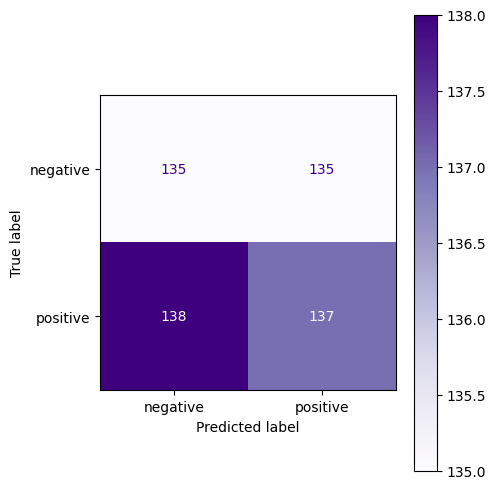

In [15]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Purples')
plt.tight_layout()
plt.show()

#STEP 3: Extract the explanation features for each pair of documents and predicted labels


In [16]:
#Extract relevant features
feature_explained_df = pd.DataFrame(classifier.explain(), index=features, columns=label_encoder.classes_)

for cls in label_encoder.classes_:
    print(f"Class '{cls}' top features:")
    print(feature_explained_df[cls].sort_values(ascending=False).head(20))
    print("\n")

feature_explained_df['features'] = feature_explained_df.index

Class 'negative' top features:
dial          0.030220
mouth         0.028714
inbox         0.026902
lower         0.025088
hardware      0.024167
wonky         0.023357
garble        0.022830
mssg          0.022419
signup        0.022158
geat          0.022128
beep          0.021962
handset       0.021948
inaudible     0.021944
promise       0.021687
triple        0.021066
overprice     0.021017
riddle        0.020872
supposedly    0.020137
monie         0.020133
reboot        0.020015
Name: negative, dtype: float64


Class 'positive' top features:
fantastic     0.027746
awsome        0.027594
atleast       0.026173
lifesaver     0.021952
earphone      0.021789
xbox          0.020643
instant       0.020585
wickr         0.020472
codei         0.020196
reverse       0.019955
whisper       0.019636
restricted    0.019380
pleased       0.019293
podcast       0.018913
february      0.018513
amazingly     0.018465
tether        0.018298
superb        0.018226
crossover     0.018215
voip    

In [17]:
all_subject_object_nouns = set(df_balanced['subject_object_nouns'].explode().dropna())

#Filter the features present in set 'all_subject_object_nouns'
filtered_features_df = feature_explained_df[feature_explained_df['features'].isin(all_subject_object_nouns)]

for cls in label_encoder.classes_:
    print(f"Class '{cls}' top features (filtered for subject/object nouns):")
    print(filtered_features_df[cls].sort_values(ascending=False).head(20))
    print("\n")


Class 'negative' top features (filtered for subject/object nouns):
dial         0.030220
inbox        0.026902
hardware     0.024167
mssg         0.022419
geat         0.022128
beep         0.021962
reboot       0.020015
sever        0.019716
asap         0.019111
trick        0.018783
action       0.018757
luck         0.016662
clock        0.015702
glitching    0.015439
buissness    0.015314
prof         0.014835
refresh      0.014817
wheel        0.014803
talkatone    0.014586
invasion     0.014531
Name: negative, dtype: float64


Class 'positive' top features (filtered for subject/object nouns):
awsome       0.027594
atleast      0.026173
earphone     0.021789
codei        0.020196
whisper      0.019636
voip         0.018099
cellphone    0.018057
buck         0.017958
hiking       0.017947
position     0.017453
txting       0.017405
extension    0.017055
comms        0.016880
specialy     0.016616
pack         0.016468
landline     0.016364
question     0.016250
island       0.0160

In [18]:
negative_values = list(filtered_features_df[filtered_features_df['negative'] != 0.0]['negative'])
quantile_neg = np.quantile(negative_values, 0.75)
print(f"Value of 75th percentile (third quartile): {quantile_neg}")
negative_aspects = filtered_features_df[filtered_features_df['negative'] >= quantile_neg]

Value of 75th percentile (third quartile): 0.004869948931493131


In [19]:
positive_values = list(filtered_features_df[filtered_features_df['positive'] != 0.0]['positive'])
quantile_pos = np.quantile(positive_values, 0.75)
print(f"Value of 75th percentile (third quartile): {quantile_pos}")
positive_aspects = filtered_features_df[filtered_features_df['positive'] >= quantile_pos]

Value of 75th percentile (third quartile): 0.005372458119037873


In [20]:
negative_aspects.sort_values(by='negative', ascending=False).head()

,negative,positive,features
dial,0.030220,0.00616,dial
inbox,0.026902,0.00000,inbox
hardware,0.024167,0.00000,hardware
mssg,0.022419,0.00000,mssg
geat,0.022128,0.00000,geat


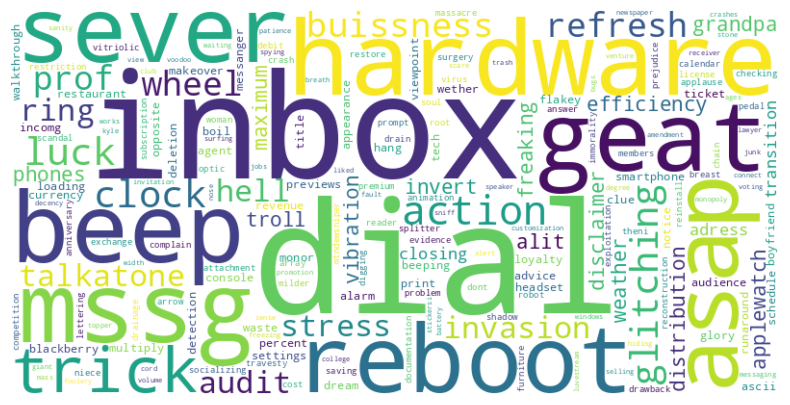

In [21]:
#NEGATIVE WORD CLOUD
text_neg = dict(zip(negative_aspects['features'], negative_aspects['negative']))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    contour_width=1.5
).generate_from_frequencies(text_neg)

#Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
positive_aspects.sort_values(by='positive', ascending=True).head()

,negative,positive,features
exiting,0.000000,0.005378,exiting
member,0.003233,0.005380,member
crash,0.008351,0.005396,crash
problem,0.007836,0.005408,problem
waste,0.010791,0.005452,waste


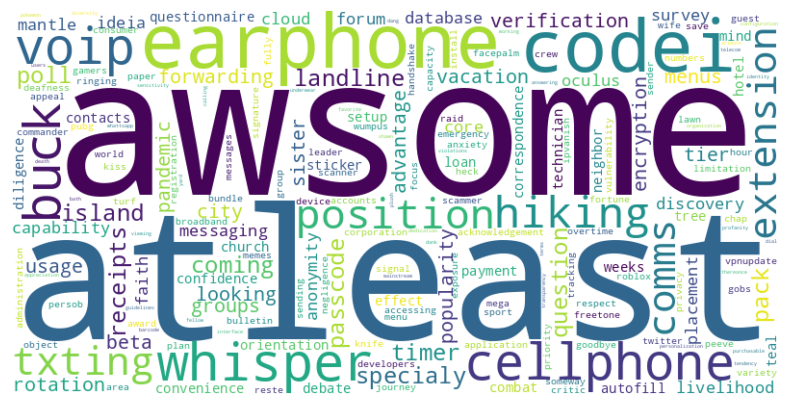

In [23]:
#POSITIVE WORD CLOUD
text_pos = dict(zip(positive_aspects['features'], positive_aspects['positive']))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='viridis',
    contour_color='steelblue',
    contour_width=1.5
).generate_from_frequencies(text_pos)

# print word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#STEP 4: Group the explanation features into candidate aspects

In [24]:
df1_expanded = df_balanced.assign(sentences=df_balanced['sentences'].str.split('|')).explode('sentences') #explode sentences
df1_expanded['sentences_lemmatized'] = df1_expanded['sentences'].apply(lambda x: " ".join(preprocess_text(x)[0])) #lemmatize sentences
df1_expanded.drop_duplicates(subset=['sentences_lemmatized', 'sentiment'], inplace=True) #drop duplicates sentences

In [25]:
positive_aspect_mapping = {keyword: 'Positive Aspect' for keyword in positive_aspects['features'].tolist()} #positive dictionary
negative_aspect_mapping = {keyword: 'Negative Aspect' for keyword in negative_aspects['features'].tolist()} #negative dictionary

# Function to associate features in the dictionaries with sentences
def assign_aspects_to_sentence(sentence, aspect_keywords, pos_tagged_tokens):
    words_in_sentence = [word.lower() for word in sentence.split()]
    matched_aspects = []
    matched_keywords = []

    #Create a token map with their POS tag and grammar dependencies
    keyword_pos_dep_map = {token[0].lower(): (token[1], token[2]) for token in pos_tagged_tokens}

    #Search values in the features
    for keyword in aspect_keywords.keys():
        if keyword in words_in_sentence:
            if keyword.lower() in keyword_pos_dep_map:
                pos, dep = keyword_pos_dep_map[keyword.lower()]
                if pos == "NOUN" and dep in {"nsubj", "dobj", "compound"}:
                    matched_aspects.append(aspect_keywords[keyword])
                    matched_keywords.append(keyword)

    if matched_aspects:
        return ", ".join(set(matched_aspects)), ", ".join(set(matched_keywords))
    else:
        return 'Unknown', 'Unknown'

# Associate positive aspects to sentences
df1_expanded[['aspect_POS', 'keyword_POS']] = df1_expanded.apply(
    lambda row: pd.Series(assign_aspects_to_sentence(row['sentences_lemmatized'], positive_aspect_mapping, row['pos_tagged'])),
    axis=1
)

# Associate negative aspects to sentences
df1_expanded[['aspect_NEG', 'keyword_NEG']] = df1_expanded.apply(
    lambda row: pd.Series(assign_aspects_to_sentence(row['sentences_lemmatized'], negative_aspect_mapping, row['pos_tagged'])),
    axis=1
)

df1_expanded.head()

,review,sentiment,term,doc_id,lemmatized_text,pos_tagged,sentences,subject_object_nouns,sentences_lemmatized,aspect_POS,keyword_POS,aspect_NEG,keyword_NEG
41,This update did nothing to fix my Bluetooth is...,negative,sound,41,update bluetooth issue despite list fix say op...,"[(update, NOUN, nsubj), (Bluetooth, PROPN, com...",This update did nothing to fix my Bluetooth is...,"[update, issues, sound, sound]",update bluetooth issue despite list fix say,Unknown,Unknown,Unknown,Unknown
41,This update did nothing to fix my Bluetooth is...,negative,sound,41,update bluetooth issue despite list fix say op...,"[(update, NOUN, nsubj), (Bluetooth, PROPN, com...",Opening the TeamSpeak app completely stops my...,"[update, issues, sound, sound]",open teamspeak completely stop iphone transmit...,Unknown,Unknown,Unknown,Unknown
41,This update did nothing to fix my Bluetooth is...,negative,sound,41,update bluetooth issue despite list fix say op...,"[(update, NOUN, nsubj), (Bluetooth, PROPN, com...",Closing TeamSpeak slows the sound to go back ...,"[update, issues, sound, sound]",closing teamspeak slow sound bluetooth speaker,Unknown,Unknown,Unknown,Unknown
1961,Discord is a great messaging service for anyon...,negative,server,1961,discord great messaging service developer thin...,"[(Discord, PROPN, nsubj), (great, ADJ, amod), ...",Discord is a great messaging service for anyone.,"[messaging, developers, possibilities, images,...",discord great messaging service,Positive Aspect,messaging,Negative Aspect,messaging
1961,Discord is a great messaging service for anyon...,negative,server,1961,discord great messaging service developer thin...,"[(Discord, PROPN, nsubj), (great, ADJ, amod), ...","Developers, G a m e r s, and anything else...","[messaging, developers, possibilities, images,...",developers think possibility pretty high possi...,Positive Aspect,developers,Unknown,Unknown


In [26]:
# Filter positive aspects
positive_aspects_df = df1_expanded[df1_expanded['aspect_POS'] != 'Unknown'].drop(['aspect_NEG', 'keyword_NEG'], axis=1)

# Filter negative aspects
negative_aspects_df = df1_expanded[df1_expanded['aspect_NEG'] != 'Unknown'].drop(['aspect_POS', 'keyword_POS'], axis=1)

In [27]:
cat_counts_p = positive_aspects_df['sentiment'].value_counts()
cat_counts_p

,count
sentiment,
positive,565
negative,374


In [28]:
cat_counts_n = negative_aspects_df['sentiment'].value_counts()
cat_counts_n

,count
sentiment,
negative,573
positive,414


#STEP 5: Predict the sentiment for the sentence or text portion using the trained Born classifier

In [29]:
pos_label = label_encoder.transform(positive_aspects_df['sentiment']) #encode sentiment
neg_label = label_encoder.transform(negative_aspects_df['sentiment']) #encode sentiment

In [30]:
vectorized_text_pos = vectorizer.transform(positive_aspects_df['sentences_lemmatized']).toarray() #the vectorizer was already fitted, use only transform now
pos_final_pred = classifier.predict(vectorized_text_pos)

print(classification_report(pos_label, pos_final_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.62      0.42      0.50       374
    positive       0.68      0.83      0.75       565

    accuracy                           0.67       939
   macro avg       0.65      0.62      0.62       939
weighted avg       0.66      0.67      0.65       939



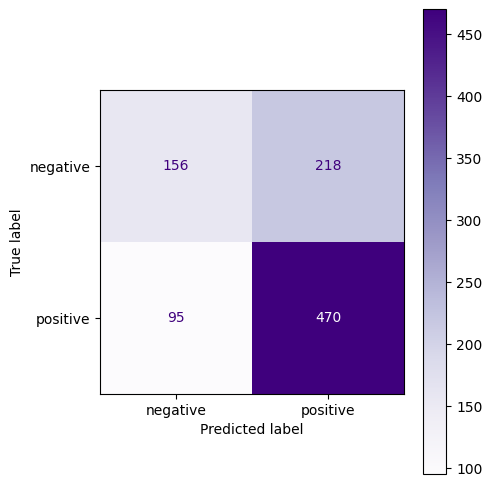

In [31]:
cm = confusion_matrix(pos_label, pos_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Purples')
plt.tight_layout()
plt.show()

In [32]:
vectorized_text_neg = vectorizer.transform(negative_aspects_df['sentences_lemmatized']).toarray()
neg_final_pred = classifier.predict(vectorized_text_neg)

print(classification_report(neg_label, neg_final_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.69      0.79      0.74       573
    positive       0.63      0.50      0.56       414

    accuracy                           0.67       987
   macro avg       0.66      0.64      0.65       987
weighted avg       0.66      0.67      0.66       987



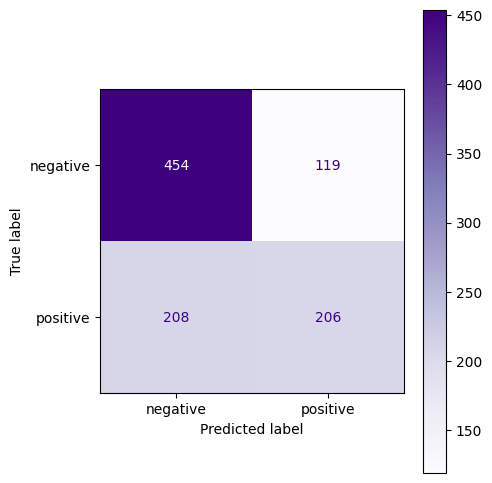

In [33]:
cm = confusion_matrix(neg_label, neg_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Purples')
plt.tight_layout()
plt.show()

#STEP 6: Associate then a (potentially different) sentiment to each sentence or text portion according to the aspect

In [34]:
y_prob_pos = classifier.predict_proba(vectorized_text_pos)
y_prob_neg = classifier.predict_proba(vectorized_text_neg)

In [35]:
# Create DF with probabilities - POSITIVE
probability_df_pos = pd.DataFrame(y_prob_pos, pos_label, columns=label_encoder.classes_)
probability_df_pos['predicted_label'] = label_encoder.inverse_transform(pos_final_pred)
probability_df_pos['original_label'] = label_encoder.inverse_transform(pos_label)

probability_df_pos['sentences'] = positive_aspects_df['sentences'].values
probability_df_pos['doc_id'] = positive_aspects_df['doc_id'].values
probability_df_pos['sentences_lemmatized']= positive_aspects_df['sentences_lemmatized'].values
probability_df_pos['keyword_POS']= positive_aspects_df['keyword_POS'].values

In [36]:
for i in range(len(probability_df_pos)):
    print(f"Doc id:")
    print(probability_df_pos.iloc[i]['doc_id'])
    print("Original Text:")
    print(probability_df_pos.iloc[i]['sentences'])
    print("Lemmatized text:")
    print(probability_df_pos.iloc[i]['sentences_lemmatized'])
    print("\nPredicted Label:")
    print(probability_df_pos.iloc[i]['predicted_label'])
    print("\nOriginal label:")
    print(probability_df_pos.iloc[i]['original_label'])
    print("\nKeyword:")
    print(probability_df_pos.iloc[i]['keyword_POS'])

    print("-" * 50)

Output streaming troncato alle ultime 5000 righe.
positive

Original label:
positive

Keyword:
debate
--------------------------------------------------
Doc id:
1348
Original Text:
 We might know more about things than your phony mainstream media and corporate science “fact checkers.” 
Lemmatized text:
know thing phony mainstream medium corporate science fact checker

Predicted Label:
positive

Original label:
positive

Keyword:
mainstream
--------------------------------------------------
Doc id:
1349
Original Text:
I’ve been using Discord for like, forever now, and this new mobile interface is cool I guess. 
Lemmatized text:
discord like forever mobile interface cool guess

Predicted Label:
positive

Original label:
positive

Keyword:
interface
--------------------------------------------------
Doc id:
1349
Original Text:
 I just wanted to let y’all know about a glitch that happens with the new @ menu and stuff. 
Lemmatized text:
want know glitch happen menu stuff

Predicted Label:
p

In [38]:
# Create DF with probabilities - NEGATIVE
probability_df_neg = pd.DataFrame(y_prob_neg, neg_label, columns=label_encoder.classes_)
probability_df_neg['predicted_label'] = label_encoder.inverse_transform(neg_final_pred)
probability_df_neg['original_label'] = label_encoder.inverse_transform(neg_label)

probability_df_neg['sentences'] = negative_aspects_df['sentences'].values
probability_df_neg['doc_id'] = negative_aspects_df['doc_id'].values
probability_df_neg['sentences_lemmatized']= negative_aspects_df['sentences_lemmatized'].values
probability_df_neg['keyword_NEG']= negative_aspects_df['keyword_NEG'].values

In [39]:
for i in range(len(probability_df_neg)):
    print(f"Doc id:")
    print(probability_df_neg.iloc[i]['doc_id'])
    print("Original text:")
    print(probability_df_neg.iloc[i]['sentences'])
    print("Lemmatized text:")
    print(probability_df_neg.iloc[i]['sentences_lemmatized'])
    print("\nPredicted Label:")
    print(probability_df_neg.iloc[i]['predicted_label'])
    print("\nOriginal label:")
    print(probability_df_neg.iloc[i]['original_label'])
    print("\nKeyword:")
    print(probability_df_neg.iloc[i]['keyword_NEG'])

    print("-" * 50)

Output streaming troncato alle ultime 5000 righe.
negative

Original label:
positive

Keyword:
restore
--------------------------------------------------
Doc id:
805
Original text:
 I call Apple to take the action against this developer/publisher. 
Lemmatized text:
apple action developer publisher

Predicted Label:
negative

Original label:
positive

Keyword:
action
--------------------------------------------------
Doc id:
830
Original text:
 The reason for not giving 5 stars is that the method of doing so is not intuitive and doesn’t really make sense. 
Lemmatized text:
reason not give star method not intuitive not sense

Predicted Label:
negative

Original label:
positive

Keyword:
sense
--------------------------------------------------
Doc id:
848
Original text:
 I want to be able to see photos that are posted in our group chats, but that doesn't mean I want it DOWNLOADED INTO MY PHONE LIBRARY. 
Lemmatized text:
want able photo post group chat not mean want download phone library


In [40]:
doc_ids = [3085, 3077, 3018, 2988]
filtered_rows = df_balanced[df_balanced['doc_id'].isin(doc_ids)]
documents_and_sentiments = filtered_rows[['review', 'sentiment', 'pos_tagged']]
documents_and_sentiments.head(10)

,review,sentiment,pos_tagged
2988,Constantly adding idiotic “enhancements” - a f...,positive,"[(Constantly, ADV, advmod), (adding, VERB, csu..."
3018,This used to be my favorite social media app a...,positive,"[(favorite, ADJ, amod), (social, ADJ, amod), (..."
3077,Thoughts - I love WhatsApp as a messenger. Eve...,positive,"[(Thoughts, NOUN, npadvmod), (love, VERB, ROOT..."
3085,Discord is a great app to connect with friends...,positive,"[(Discord, PROPN, nsubj), (great, ADJ, amod), ..."


Analyzing common features in candidate aspects

In [41]:
positive_aspects_set = set(positive_aspects['features'])
negative_aspects_set = set(negative_aspects['features'])

common_aspects = positive_aspects_set.intersection(negative_aspects_set)

common_df = positive_aspects[positive_aspects['features'].apply(lambda x: x in common_aspects)]
common_df.head(40)

,negative,positive,features
application,0.005021,0.008714,application
crash,0.008351,0.005396,crash
device,0.005448,0.009531,device
dial,0.030220,0.006160,dial
encryption,0.005303,0.012521,encryption
group,0.005035,0.007290,group
messaging,0.006251,0.012331,messaging
mind,0.005117,0.010632,mind
problem,0.007836,0.005408,problem
refresh,0.014817,0.005753,refresh


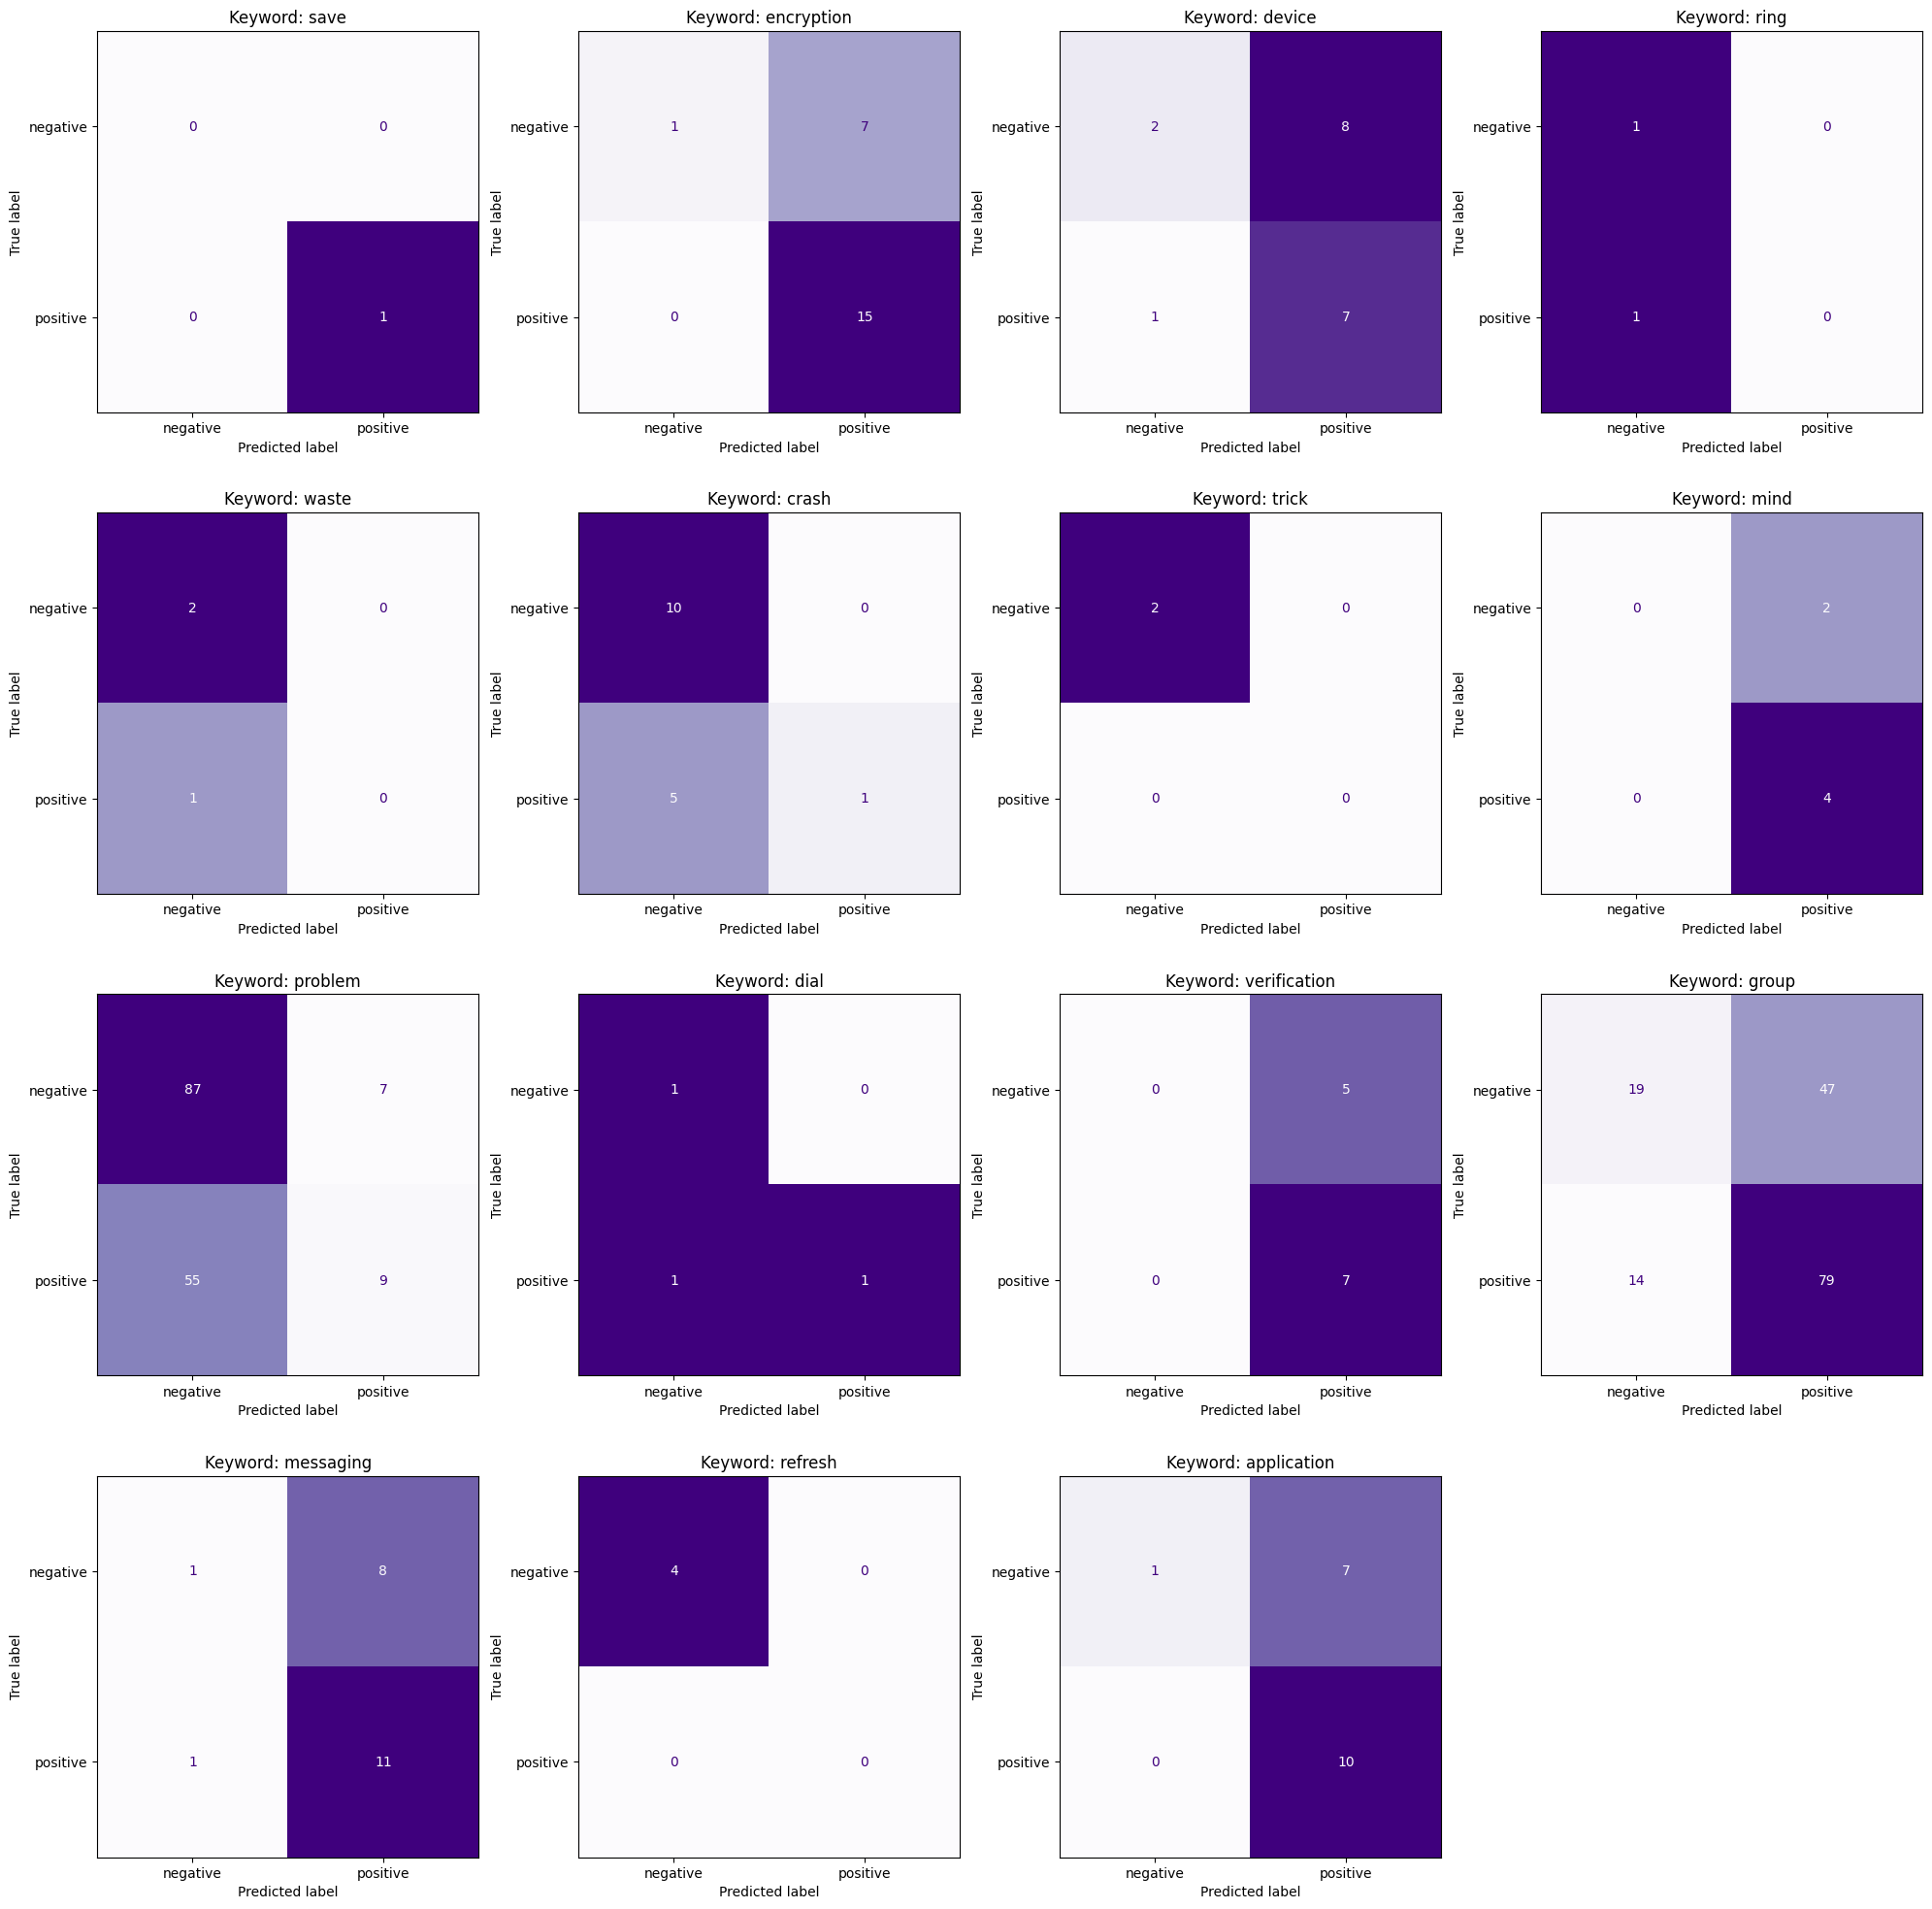

In [42]:
#Plot confusion matrix common features in probability_df_pos
def plot_confusion_matrix_for_word(word, df, ax):
    filtered_df = probability_df_pos[probability_df_pos['keyword_POS'] == word]
    if not filtered_df.empty:
        cm = confusion_matrix(filtered_df['original_label'], filtered_df['predicted_label'], labels=["negative", "positive"])
        if cm.shape == (1, 1):
            cm = np.array([[cm[0, 0], 0], [0, 0]])
        ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"]).plot(ax=ax, cmap='Purples', colorbar=False)
        ax.set_title(f'Keyword: {word}')
    else:
        ax.set_title(f'No data for keyword: {word}')
        ax.axis('off')

n_cols = 4
n_rows = (len(common_aspects) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for ax, word in zip(axes, common_aspects):
    plot_confusion_matrix_for_word(word, probability_df_pos, ax)

for ax in axes[len(common_aspects):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [43]:
predictions_df_pos = probability_df_pos[
    (probability_df_pos['predicted_label'] == 'negative') &
    (probability_df_pos['original_label'] == 'negative') &
    (probability_df_pos['keyword_POS'] == 'application')
]
for i in range(len(predictions_df_pos)):
    print(f"Doc id:")
    print(predictions_df_pos.iloc[i]['doc_id'])
    print("Original Text:")
    print(predictions_df_pos.iloc[i]['sentences'])
    print("Lemmatized text:")
    print(predictions_df_pos.iloc[i]['sentences_lemmatized'])
    print("\nPredicted Label:")
    print(predictions_df_pos.iloc[i]['predicted_label'])
    print("\nOriginal label:")
    print(predictions_df_pos.iloc[i]['original_label'])
    print("\nKeyword:")
    print(predictions_df_pos.iloc[i]['keyword_POS'])

    print("-" * 50)

Doc id:
666
Original Text:
 They are neglecting basic application decency that their competitors have already stepped up with. 
Lemmatized text:
neglect basic application decency competitor step

Predicted Label:
negative

Original label:
negative

Keyword:
application
--------------------------------------------------


In [44]:
#Find all the reviews in the original dataset that contain "verification"
verification_check = 'verification'
verification_df = df_balanced[df_balanced['review'].str.contains(verification_check, case=False, na=False)]
ver = verification_df[['review', 'sentiment']]
ver.head(200)

,review,sentiment
682,My account was hacked by someone who changed m...,negative
2603,"Dear discord,Right now I’m extremely mad and f...",negative
368,If you want to use this app for business or so...,negative
392,I don’t know who thought it would be a good id...,negative
1264,"there should be NO verifications. 1, I’m cryin...",negative
236,A well-developed and clean interface on top of...,positive
395,Very good app so far. Only me thing. I didn't ...,positive
505,This app is pretty decent for instant messagin...,positive
921,My account was hacked by someone who changed m...,positive
1003,"Hey, so. I started to use this app so i could ...",positive


In [45]:
change_positive_keywords = {'application','device' , 'encryption', 'group', 'messaging', 'mind'}

positive_aspects_df['sentiment'] = positive_aspects_df.apply(
    lambda row: 'positive' if row['keyword_POS'] in change_positive_keywords else row['sentiment'], axis=1) #change the sentiment in positive_aspects_df

negative_aspects_df = negative_aspects_df[~negative_aspects_df['keyword_NEG'].isin(change_positive_keywords)] #remove positive keywords from negative_aspects_df

In [46]:
change_negative_keywords = {'crash', 'problem' 'refresh', 'ring','trick', 'waste', 'save', 'verification'}

negative_aspects_df['sentiment'] = negative_aspects_df.apply(
    lambda row: 'negative' if row['keyword_NEG'] in change_negative_keywords else row['sentiment'], axis=1) #change the sentiment in negative_aspects_df

positive_aspects_df = positive_aspects_df[~positive_aspects_df['keyword_POS'].isin(change_negative_keywords)] #remove negative keywords from positive_aspects_df

New prediction with changed sentiments

In [47]:
pos_label = label_encoder.transform(positive_aspects_df['sentiment'])
neg_label = label_encoder.transform(negative_aspects_df['sentiment'])

In [48]:
vectorized_text_pos = vectorizer.transform(positive_aspects_df['sentences_lemmatized']).toarray()
pos_final_pred = classifier.predict(vectorized_text_pos)

In [49]:
print(classification_report(pos_label, pos_final_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.51      0.47      0.49       251
    positive       0.80      0.83      0.81       652

    accuracy                           0.73       903
   macro avg       0.66      0.65      0.65       903
weighted avg       0.72      0.73      0.72       903



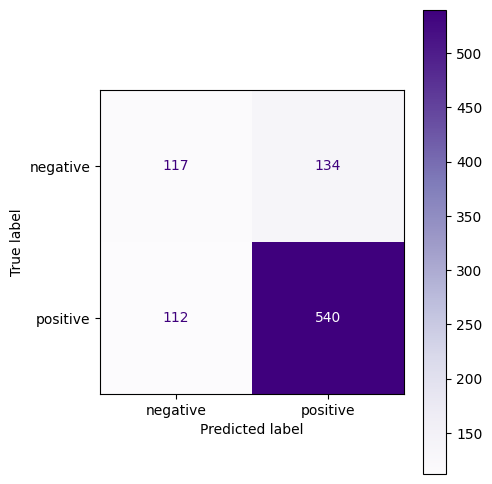

In [50]:
cm = confusion_matrix(pos_label, pos_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Purples')
plt.tight_layout()
plt.show()

In [51]:
vectorized_text_neg = vectorizer.transform(negative_aspects_df['sentences_lemmatized']).toarray()
neg_final_pred = classifier.predict(vectorized_text_neg)

In [52]:
print(classification_report(neg_label, neg_final_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.70      0.90      0.79       488
    positive       0.54      0.23      0.32       241

    accuracy                           0.68       729
   macro avg       0.62      0.57      0.56       729
weighted avg       0.65      0.68      0.64       729



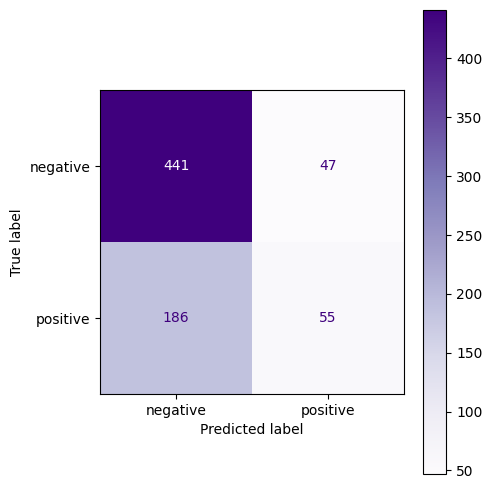

In [53]:
cm = confusion_matrix(neg_label, neg_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Purples')
plt.tight_layout()
plt.show()